In [60]:


import pandas_datareader.data as web
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
from pandas_datareader._utils import RemoteDataError
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
plt.rcParams['figure.figsize'] = [10, 6]
import warnings
warnings.filterwarnings('ignore')


#### Stratgey : Look for the past data, get stocks where volumes of today and yesterday are both postive and prior to that there were two days with negative volume, additional look for the past where we have certain pattern for macd, intersection for example?
---

- Our investigation space will be the list of stocks in series_tickers file

In [61]:
#Download file "series_tickers.p" from github or create your own list of tickers
series_tickers = pickle.load(open("series_tickers.p", "rb" ))

-  here will create a class for the stock

In [68]:
class stock:
    def __init__(self,stock = 'NIO',price = 'Adj Close'):
        self.stock = stock
        self.price = price
    
    def get_df(self):
        
        '''
        volume trading create a data frame for the stocks and manipulate it, a new column reflecting postive or negative is created, green for postive
        and red for negative
        
        inputs: 
        ------
        None
        
        returns:
        ------ 
        df : a dataframe which will be used with the subsequent  functions
        '''
        price = self.price
        end_date = datetime.now().date()
        start_date = (datetime.now() - timedelta(days=360)).date()    
        df = web.DataReader(self.stock, 'yahoo', start=start_date, end=end_date)
        df = df.reset_index()

        df['close_before'] = df[price].shift(1) 
        df['relative_price'] = df[price] - df['close_before']
        df["Color"] = np.where(df["relative_price"]<0, 'red', 'green')

        df = df.iloc[::-1]
        df = df.reset_index(drop = True)
        df = df.fillna(0)
        self.df = df
        return self.df 
    
    def macd(self):
        
        '''
        macd trading, create a data frame for the stocks and manipulate it, a new column reflecting postive or negative is created, green for when macd is above the signal line
        and red for when when the macd is below singal line
        
        inputs: 
        ------
        None
        
        returns:
        ------ 
        df : a dataframe which will be used with the subsequent  functions
        '''

        
        df = self.df
        df = df.iloc[::-1]
        #Calculate the MACD and Signal Line indicators
        #Calculate the Short Term Exponential Moving Average
        ShortEMA = df['Adj Close'].ewm(span=12, adjust=False).mean() #AKA Fast moving average
        #Calculate the Long Term Exponential Moving Average
        LongEMA = df['Adj Close'].ewm(span=26, adjust=False).mean() #AKA Slow moving average

        #ShortEMA = df['Adj Close'].rolling(window = 12).mean() #AKA Fast moving average
        #Calculate the Long Term Exponential Moving Average
        #LongEMA = df['Adj Close'].rolling(window = 26).mean() #AKA Slow moving average
        #Calculate the Moving Average Convergence/Divergence (MACD)
        MACD = ShortEMA - LongEMA
        #Calcualte the signal line
        signal = MACD.ewm(span=9, adjust=False).mean()
        #signal = MACD.rolling(window = 9).mean()

        df['macd'] = MACD
        df['signal'] = signal

        df['macd_above'] = np.where(df['macd'] > df['signal'],'green','red')
        
        self.df2 = df[::-1]

        return self.df2
    def moving_avg(self,time_frame = 50):
        
        '''
        macd trading, create a data frame for the stocks and manipulate it, a new column reflecting postive or negative is created, green for when macd is above the signal line
        and red for when when the macd is below singal line
        
        inputs: 
        ------
        None
        
        returns:
        ------ 
        df : a dataframe which will be used with the subsequent  functions
        '''

        
        df = self.df
        df = df.iloc[::-1]
        #Calculate the MACD and Signal Line indicators
        #Calculate the Short Term Exponential Moving Average
        df['moving_avg'] =df['Close'].rolling(window=time_frame).mean()
    
        df['status_moving_avg'] = np.where(df['Close'] > df['moving_avg'],'green','red')
            
        self.df2 = df[::-1]

        return self.df2
        
    def is_this_a_winner_moving_avg(self,colors = ['green','green','green','red']):
        '''
        macd trading, given a condition by the user this function will return wether a stock matches that condition or not        
        inputs: 
        ------
        colors : list of colors for today and the previous 3 days, green indicates a positive volume and red indicates a negative volume
        
        returns:
        ------
        result : Boolean, True if the conditions in the colors list are met
        
        '''
        
        df = self.df2
        result = np.where(df['status_moving_avg'][0]== colors[0] and df['status_moving_avg'][1]==colors[1] and df['status_moving_avg'][2]==colors[2]and df['status_moving_avg'][3]==colors[3],True,False)
        #result = np.where(df['Color'][0]=='green' and df['Color'][1]=='red' and df['Color'][2]=='red' and df['Color'][3]=='red' ,True,False)
        return result[()]
    
    
    
    
    def is_this_a_winner(self,colors = ['green','green','red','red']):
        '''
        volume trading, given a condition by the user this function will return wether a stock matches that condition or not        
        inputs: 
        ------
        colors : list of colors for today and the previous 3 days, green indicates a positive volume and red indicates a negative volume
        
        returns:
        ------
        result : Boolean, True if the conditions in the colors list are met
        
        '''
        
        df = self.df
        result = np.where(df['Color'][0]== colors[0] and df['Color'][1]==colors[1] and df['Color'][2]==colors[2] and df['Color'][3]==colors[3],True,False)
        #result = np.where(df['Color'][0]=='green' and df['Color'][1]=='red' and df['Color'][2]=='red' and df['Color'][3]=='red' ,True,False)
        return result[()]
        
    def is_this_a_winner_macd(self,colors = ['green','green','red']):
        '''
        macd trading, given a condition by the user this function will return wether a stock matches that condition or not        
        inputs: 
        ------
        colors : list of colors for today and the previous 3 days, green indicates a positive volume and red indicates a negative volume
        
        returns:
        ------
        result : Boolean, True if the conditions in the colors list are met
        
        '''
        
        df = self.df2
        result = np.where(df['macd_above'][0]== colors[0] and df['macd_above'][1]==colors[1] and df['macd_above'][2]==colors[2],True,False)
        #result = np.where(df['Color'][0]=='green' and df['Color'][1]=='red' and df['Color'][2]=='red' and df['Color'][3]=='red' ,True,False)
        return result[()]
    
    def plot_df(self):
        '''
        displays a bar plot for the volume over time,green bar for positivie volume and red bar for negative volume         
        inputs: 
        '''   
        df = self.df

        df1 = df[df['relative_price']<0]
        df2 = df[df['relative_price']>=0]
        plt.bar(df1['Date'], df1['Volume'], color='r')
        plt.bar(df2['Date'], df2['Volume'], color='g')
        plt.show()
        return 
    

In [63]:
### Example: volume trading :

# how about TSLA
tsla = stock('TSLA')
tsla.get_df()

,Date,High,Low,Open,Close,Volume,Adj Close,close_before,relative_price,Color
0,2020-10-23,422.885895,407.380096,421.839996,415.924011,22580292.0,415.924011,425.790009,-9.865997,red
1,2020-10-22,445.230011,424.510010,441.920013,425.790009,39825200.0,425.790009,422.640015,3.149994,green
2,2020-10-21,432.950012,421.250000,422.700012,422.640015,32370500.0,422.640015,421.940002,0.700012,green
3,2020-10-20,431.750000,419.049988,431.750000,421.940002,31656300.0,421.940002,430.829987,-8.889984,red
4,2020-10-19,447.000000,428.869995,446.239990,430.829987,36287800.0,430.829987,439.670013,-8.840027,red
...,...,...,...,...,...,...,...,...,...,...
245,2019-11-04,64.388000,61.852001,62.959999,63.493999,43935000.0,63.493999,62.661999,0.832001,green
246,2019-11-01,63.296001,61.959999,63.264000,62.661999,31919500.0,62.661999,62.984001,-0.322002,red
247,2019-10-31,63.799999,62.599998,62.619999,62.984001,25335000.0,62.984001,63.001999,-0.017998,red
248,2019-10-30,63.757999,61.993999,62.599998,63.001999,48209000.0,63.001999,63.243999,-0.242001,red


In [64]:
# let's test TSLA stock with a condition that we know it does meet


conditions= ['green','red','red','red'] 


tsla.is_this_a_winner(colors = conditions)

False

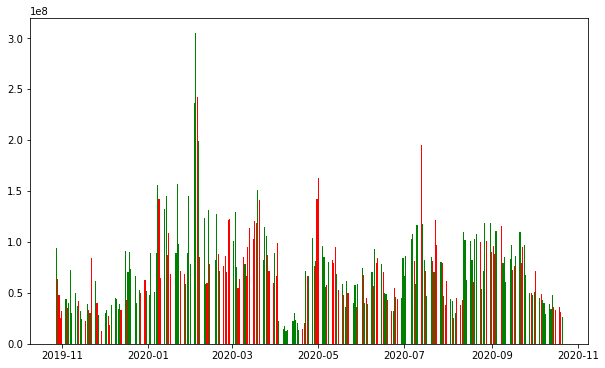

In [48]:
tsla.plot_df()

In [53]:
### Example: 
# macd trading

# let's try TSLA stock again but using macd strategy

In [49]:
uber = stock('TSLA')

In [54]:
# first we will have a look at the dataframe we have

uber.macd()


,Date,High,Low,Open,Close,Volume,Adj Close,close_before,relative_price,Color,macd,signal,macd_above
0,2020-10-21,36.209999,34.875099,36.250000,35.189999,17792109,35.189999,36.310001,-1.120003,red,0.021383,0.265330,red
1,2020-10-20,36.759998,34.529999,34.529999,36.310001,29780800,36.310001,34.220001,2.090000,green,0.048978,0.326316,red
2,2020-10-19,34.590000,34.000000,34.160000,34.220001,19278600,34.220001,33.720001,0.500000,green,-0.030550,0.395651,red
3,2020-10-16,34.799999,33.610001,34.779999,33.720001,14899700,33.720001,34.259998,-0.539997,red,0.081187,0.502201,red
4,2020-10-15,34.810001,34.020000,34.680000,34.259998,15443800,34.259998,35.110001,-0.850002,red,0.273533,0.607454,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2019-11-01,31.700001,30.740999,31.450001,31.370001,10434300,31.370001,31.500000,-0.129999,red,-0.256314,-0.081394,red
245,2019-10-31,33.360001,31.260000,33.230000,31.500000,15912400,31.500000,33.750000,-2.250000,red,-0.141880,-0.037664,red
246,2019-10-30,33.799999,32.110001,32.509998,33.750000,10732700,33.750000,32.419998,1.330002,green,-0.006993,-0.011610,green
247,2019-10-29,32.919998,31.815001,32.369999,32.419998,9319200,32.419998,33.220001,-0.800003,red,-0.063818,-0.012764,red


In [56]:
uber.is_this_a_winner_macd(colors = ['red','red','red'])

True

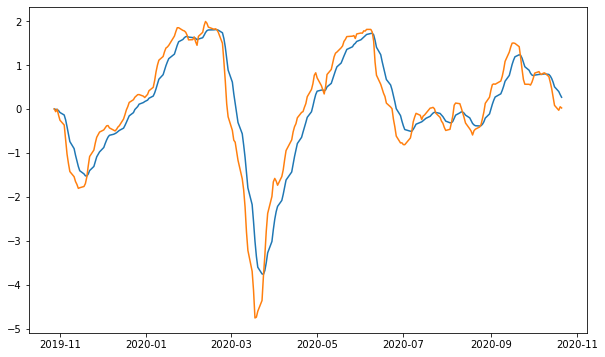

In [36]:
# let's plot the result for macd

df = uber.macd()
plt.plot(df['Date'],df['signal'])
plt.plot(df['Date'],df['macd']);


>Voila, the code works fine

### Hunting for winners

- Now let's look at out list of stocks and find ones that meet our condition

Vonage Holdings Corp. - Common Stock is not a winner
Cadence Design Systems, Inc. - Common Stock is not a winner
Urban One, Inc.  - Class A Common Stock is not a winner
Broadcom Inc. - Common Stock is not a winner
Adobe Inc. - Common Stock is not a winner
Alexion Pharmaceuticals, Inc. - Common Stock is not a winner
Limelight Networks, Inc. - Common Stock is not a winner
Maxim Integrated Products, Inc. - Common Stock is not a winner
Ares Capital Corporation - Closed End Fund is not a winner
Costco Wholesale Corporation - Common Stock is not a winner
Genius Brands International, Inc. - Common Stock is not a winner
Foresight Autonomous Holdings Ltd. - American Depositary Shares is not a winner
Curis, Inc. - Common Stock is not a winner
NortonLifeLock Inc. - Common Stock is not a winner
Gevo, Inc. - Common Stock is not a winner
Digital Ally, Inc. - Common Stock is not a winner
Qurate Retail, Inc. - Series A Common Stock is not a winner
Marriott International - Class A Common Stock is not a

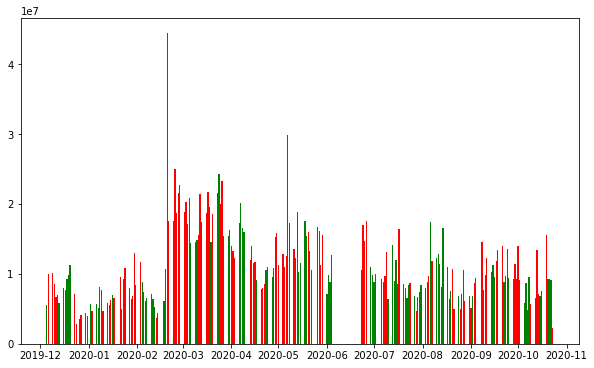

The Carlyle Group Inc. - Common Stock is not a winner
OpGen, Inc. - Common Stock is not a winner
PepsiCo, Inc. - Common Stock is not a winner
Workday, Inc. - Class A Common Stock is not a winner
ImmunoGen, Inc. - Common Stock is not a winner
AYRO, Inc. - Common Stock is not a winner
Vanguard Total International Bond ETF is not a winner
Teradyne, Inc. - Common Stock is not a winner
Zillow Group, Inc. - Class C Capital Stock is not a winner
The Goodyear Tire & Rubber Company - Common Stock is not a winner
NantKwest, Inc. - Common Stock is not a winner
Dynavax Technologies Corporation - Common Stock is not a winner
Advanced Micro Devices, Inc. - Common Stock is not a winner
QUALCOMM Incorporated - Common Stock is not a winner
Arbutus Biopharma Corporation - Common Stock is not a winner
Menlo Therapeutics Inc. - Common Stock is not a winner
Waitr Holdings Inc. - Common Stock is not a winner
Aerpio Pharmaceuticals, Inc. - Common Stock is not a winner
New York Mortgage Trust, Inc. - Common S

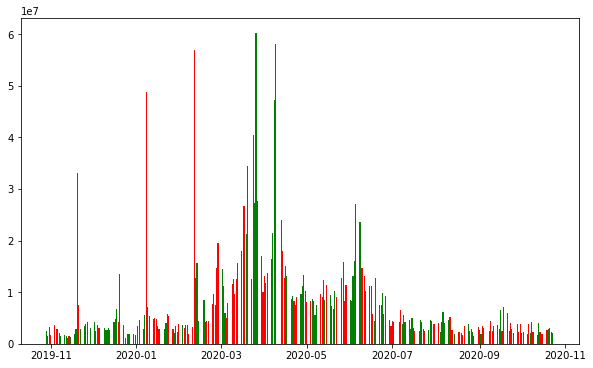

Diffusion Pharmaceuticals Inc. - Common Stock is not a winner
Kingsoft Cloud Holdings Limited - American Depositary Shares is not a winner
DENTSPLY SIRONA Inc. - Common Stock is not a winner
United Airlines Holdings, Inc. - Common Stock is not a winner
Pan American Silver Corp. - Common Stock is not a winner
Micron Technology, Inc. - Common Stock is not a winner
Comcast Corporation - Class A Common Stock is not a winner
iShares 1-3 Year Treasury Bond ETF is not a winner
Glu Mobile Inc. - Common Stock is not a winner
Fox Corporation - Class A Common Stock is not a winner
Energous Corporation - Common Stock is not a winner
Midatech Pharma PLC - American Depositary Shares is not a winner
Sprouts Farmers Market, Inc. - Common Stock is not a winner
ON Semiconductor Corporation - Common Stock is not a winner
Clovis Oncology, Inc. - Common Stock is not a winner
Sangamo Therapeutics, Inc. - Common Stock is not a winner
Dave & Buster's Entertainment, Inc. - Common Stock is not a winner
Huntingt

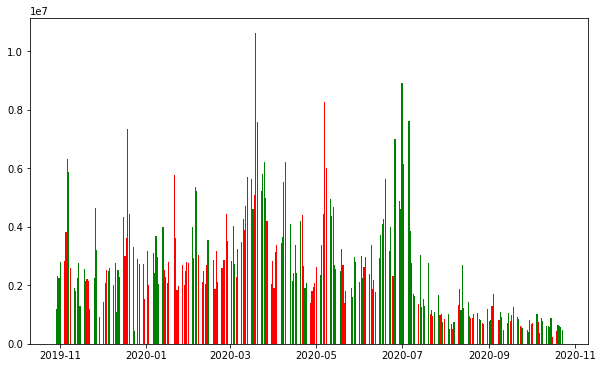

iShares Preferred and Income Securities ETF is not a winner
XpresSpa Group, Inc.  - Common Stock is not a winner
Cassava Sciences, Inc. - Common Stock is not a winner
The Kraft Heinz Company - Common Stock is not a winner
Broadway Financial Corporation - Common Stock is not a winner
Applied Materials, Inc. - Common Stock is not a winner
BioNTech SE - American Depositary Shares is not a winner
Intel Corporation - Common Stock is not a winner
Huazhu Group Limited - American Depositary Shares, each representing one Ordinary Share is not a winner
Valley National Bancorp - Common Stock is not a winner
Navient Corporation - Common Stock is not a winner
JD.com, Inc. - American Depositary Shares is not a winner
Electrameccanica Vehicles Corp. Ltd. - Common Stock is not a winner
GenMark Diagnostics, Inc. - Common Stock is not a winner
Overstock.com, Inc. - Common Stock is not a winner
Mattel, Inc. - Common Stock is not a winner
Onconova Therapeutics, Inc. - Common Stock is not a winner
iShares 

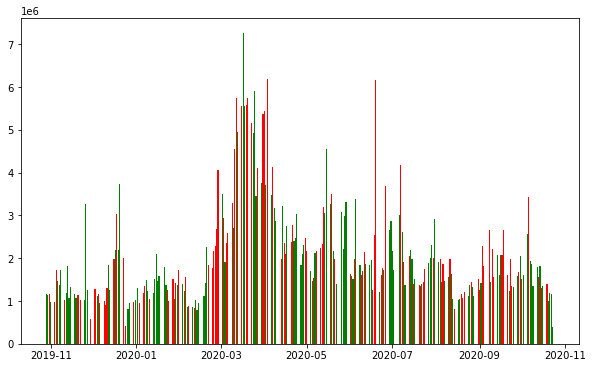

Enphase Energy, Inc. - Common Stock is not a winner
Safe-T Group Ltd. - American Depositary Shares is not a winner
Blink Charging Co. - Common Stock is not a winner
Cognizant Technology Solutions Corporation - Class A Common Stock is not a winner
Amgen Inc. - Common Stock is not a winner
Penn National Gaming, Inc. - Common Stock is not a winner
CureVac N.V. - Ordinary Shares is not a winner
Vanguard Short-Term Corporate Bond ETF is not a winner
Trevena, Inc. - Common Stock is not a winner
Adamis Pharmaceuticals Corporation - Common Stock is not a winner
ProShares UltraPro QQQ is not a winner
Skyworks Solutions, Inc. - Common Stock is not a winner
Avis Budget Group, Inc. - Common Stock is not a winner
Tonix Pharmaceuticals Holding Corp. - Common Stock is not a winner
Zscaler, Inc. - Common Stock is not a winner
Moneygram International, Inc. - Common Stock is not a winner
Hologic, Inc. - Common Stock is not a winner


In [65]:
winners = []  # a list that we will append with stocks that meet out conditions

for ticker, name in series_tickers.iteritems():
    try:
        my_stock = stock(ticker)
        my_stock.get_df()
        my_stock.macd()
        if my_stock.is_this_a_winner_macd(colors = ['green','red','red']):
            print(name,'is a winner')
            my_stock.plot_df()
            winners.append(ticker)
        else:
            print(name,'is not a winner')
    except:
        continue


- Finally let's look at the list of our winners

In [67]:
winners

['VIAC', 'NYMT', 'IAC', 'PAYX']

In [58]:
# very short list , we need to adjust the pattern so we got more stocks

In [69]:
winners_moving_avg = []  # a list that we will append with stocks that meet out conditions

#i = 0
for ticker, name in series_tickers.iteritems():
    #i = i +1
    try:
        my_stock = stock(ticker)
        my_stock.get_df()
        my_stock.moving_avg()
        if my_stock.is_this_a_winner_moving_avg(colors = ['green','green','red','red']):
            print(name,'is a winner')
            #my_stock.plot_df_ballinger()
            #my_stock.plot_df_macd()
            winners_moving_avg.append(name)
        else:
            print(name,'is not a winner')
    except:
        continue
    #if i ==1:
        #break


Vonage Holdings Corp. - Common Stock is not a winner
Cadence Design Systems, Inc. - Common Stock is not a winner
Urban One, Inc.  - Class A Common Stock is not a winner
Broadcom Inc. - Common Stock is not a winner
Adobe Inc. - Common Stock is not a winner
Alexion Pharmaceuticals, Inc. - Common Stock is not a winner
Limelight Networks, Inc. - Common Stock is not a winner
Maxim Integrated Products, Inc. - Common Stock is not a winner
Ares Capital Corporation - Closed End Fund is not a winner
Costco Wholesale Corporation - Common Stock is not a winner
Genius Brands International, Inc. - Common Stock is not a winner
Foresight Autonomous Holdings Ltd. - American Depositary Shares is not a winner
Curis, Inc. - Common Stock is not a winner
NortonLifeLock Inc. - Common Stock is not a winner
Gevo, Inc. - Common Stock is not a winner
Digital Ally, Inc. - Common Stock is not a winner
Qurate Retail, Inc. - Series A Common Stock is not a winner
Marriott International - Class A Common Stock is a win